In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from typing import Union, Optional
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined_ts2.csv')

In [4]:
df.head()

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
0,1,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,...,0.129900,0.008119,0.358576,0.032100,0.001400,0.470588,0.000000,0.647059,0.941176,0.000
1,2,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,...,7.669778,0.365228,0.020237,-0.284889,3.335466,0.409091,-0.267421,0.363636,0.681818,0.150
2,3,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,...,7.508992,3.754496,0.666738,0.000840,37.494722,1.000000,-2.505261,0.666667,0.333333,-2.490
3,4,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,5,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,...,3.404658,0.162127,0.006660,0.000342,4.594823,0.409091,0.050000,0.045455,0.954545,0.085


In [5]:
df.info

<bound method DataFrame.info of        Index                                     Address  FLAG  \
0          1  0x87d884aaa6ff9e9b6014631b0abae80b53953fb8     1   
1          2  0xd42393df90d582bd8a5493171f0173e3a017d391     1   
2          3  0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37     1   
3          4  0x6309f709faad518fc158af4c14edfa7b06424770     1   
4          5  0x3d020954e30c3d40b7f0c533cf198bc10dd45a49     1   
...      ...                                         ...   ...   
13915  13916  0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2     1   
13916  13917  0xff718805bb9199ebf024ab6acd333e603ad77c85     1   
13917  13918  0xff8e6af02d41a576a0c82f7835535193e1a6bccc     1   
13918  13919  0xffde23396d57e10abf58bd929bb1e856c7718218     1   
13919  13920  0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c     1   

       Avg min between sent tnx  Avg min between received tnx  \
0                       5151.68                      15159.08   
1                       1179.02                       1124.89   
2                        361.73                          0.00   
3                          0.00                          0.00   
4                      14280.60                       1479.86   
...                         ...                           ...   
13915                  12635.10                        631.39   
13916                      0.00                          0.00   
13917                   2499.44                       2189.29   
13918                      0.00                          0.00   
13919                  37242.70                        149.56   

       Time Diff between first and last (Mins)  \
0                                     71235.62   
1                                     25126.45   
2                                       723.47   
3                                         0.00   
4                                     45357.57   
...                                        ...   
13915                                 58748.48   
13916                                     0.00   
13917                                261601.88   
13918                                     0.00   
13919                                670817.33   

       Unique Received From Addresses  min value received  \
0                                   1            0.010000   
1                                  13            0.000000   
2                                   1            4.999916   
3                                   0            0.000000   
4                                  21            0.035000   
...                               ...                 ...   
13915                              11            0.004082   
13916                               0            0.000000   
13917                              31            0.001078   
13918                               1            0.500000   
13919                               1            0.795233   

       max value received   avg val received  ...  \
0                 0.020000          0.013367  ...   
1                 0.750000          0.176667  ...   
2                 4.999916          4.999916  ...   
3                 0.000000          0.000000  ...   
4                 0.200000          0.099286  ...   
...                    ...               ...  ...   
13915            12.000000          2.821060  ...   
13916             0.000000          0.000000  ...   
13917            21.310000          1.234192  ...   
13918             0.500000          0.500000  ...   
13919         18998.000000       6333.265078  ...   

       adjusted_eth_value__absolute_sum_of_changes  \
0                                         0.129900   
1                                         7.669778   
2                                         7.508992   
3                                         0.000000   
4                                         3.404658   
...                                            ...   
13915                                    72.1

In [6]:
df.describe()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
count,13920.000000,13920.000000,1.392000e+04,13920.000000,1.392000e+04,13920.000000,13920.000000,13920.000000,13920.000000,13920.000000,...,1.392000e+04,13920.000000,13920.000000,1.392000e+04,1.392000e+04,13920.000000,13920.000000,13920.000000,13920.000000,13920.000000
mean,6960.500000,0.451365,8.255657e+03,7139.475673,1.933551e+05,28.965302,34.827858,382.706924,77.277532,5.786684,...,1.840054e+04,49.835172,0.206893,-2.347365e+02,3.767353e+08,0.732154,-43.974980,0.428566,0.586002,1.918116
std,4018.502209,0.497647,4.326177e+04,23686.397036,3.252465e+05,270.287059,359.699858,10944.855490,2438.219016,135.625461,...,5.059423e+05,347.129817,0.255727,2.414303e+05,1.703021e+10,0.358772,358.747133,0.287203,0.301811,232.919614
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,-1.560545e+07,0.000000e+00,0.000000,-20366.891130,0.000000,0.000000,-5000.000000
25%,3480.750000,0.000000,0.000000e+00,0.000000,1.075350e+02,1.000000,0.000000,0.447267,0.164712,0.000000,...,2.332697e+00,0.185148,0.001629,0.000000e+00,1.545367e+00,0.514286,-6.428284,0.142857,0.416667,0.000000
50%,6960.500000,0.000000,2.559000e+01,216.425000,2.377318e+04,2.000000,0.034394,3.086630,1.004707,0.010000,...,2.938755e+01,1.685743,0.069679,1.554000e-03,8.818439e+01,0.950000,-0.532203,0.500000,0.538462,0.000241
75%,10440.250000,1.000000,1.605840e+03,3755.077500,2.454864e+05,6.000000,0.990000,33.294734,8.500000,0.901043,...,1.994976e+02,11.999018,0.455335,2.232345e-02,8.718736e+03,1.000000,0.000000,0.615385,0.857143,0.200127
max,13920.000000,1.000000,1.461535e+06,517161.100000,2.837470e+06,9999.000000,25533.614330,800000.000000,283618.831600,12000.000000,...,2.821505e+07,25483.614120,1.000000,1.428864e+07,1.170320e+12,1.000000,25533.614350,1.000000,1.000000,25533.614420


In [7]:
feature_list = list(set(df.columns) - set(['Address', 'FLAG']))
for feature in feature_list:
    print(feature)

total transactions (including tnx to create contract
min val sent
Avg min between received tnx
Avg min between sent tnx
adjusted_eth_value__absolute_sum_of_changes
adjusted_eth_value__quantile__q_0.1
adjusted_eth_value__sum_values
adjusted_eth_value__count_above__t_0
Unique Received From Addresses
Index
adjusted_eth_value__ratio_value_number_to_time_series_length
Time Diff between first and last (Mins)
adjusted_eth_value__mean_abs_change
adjusted_eth_value__abs_energy
max value received 
adjusted_eth_value__median
avg val received
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0
adjusted_eth_value__count_below__t_0
total ether balance
total ether received
avg val sent
min value received


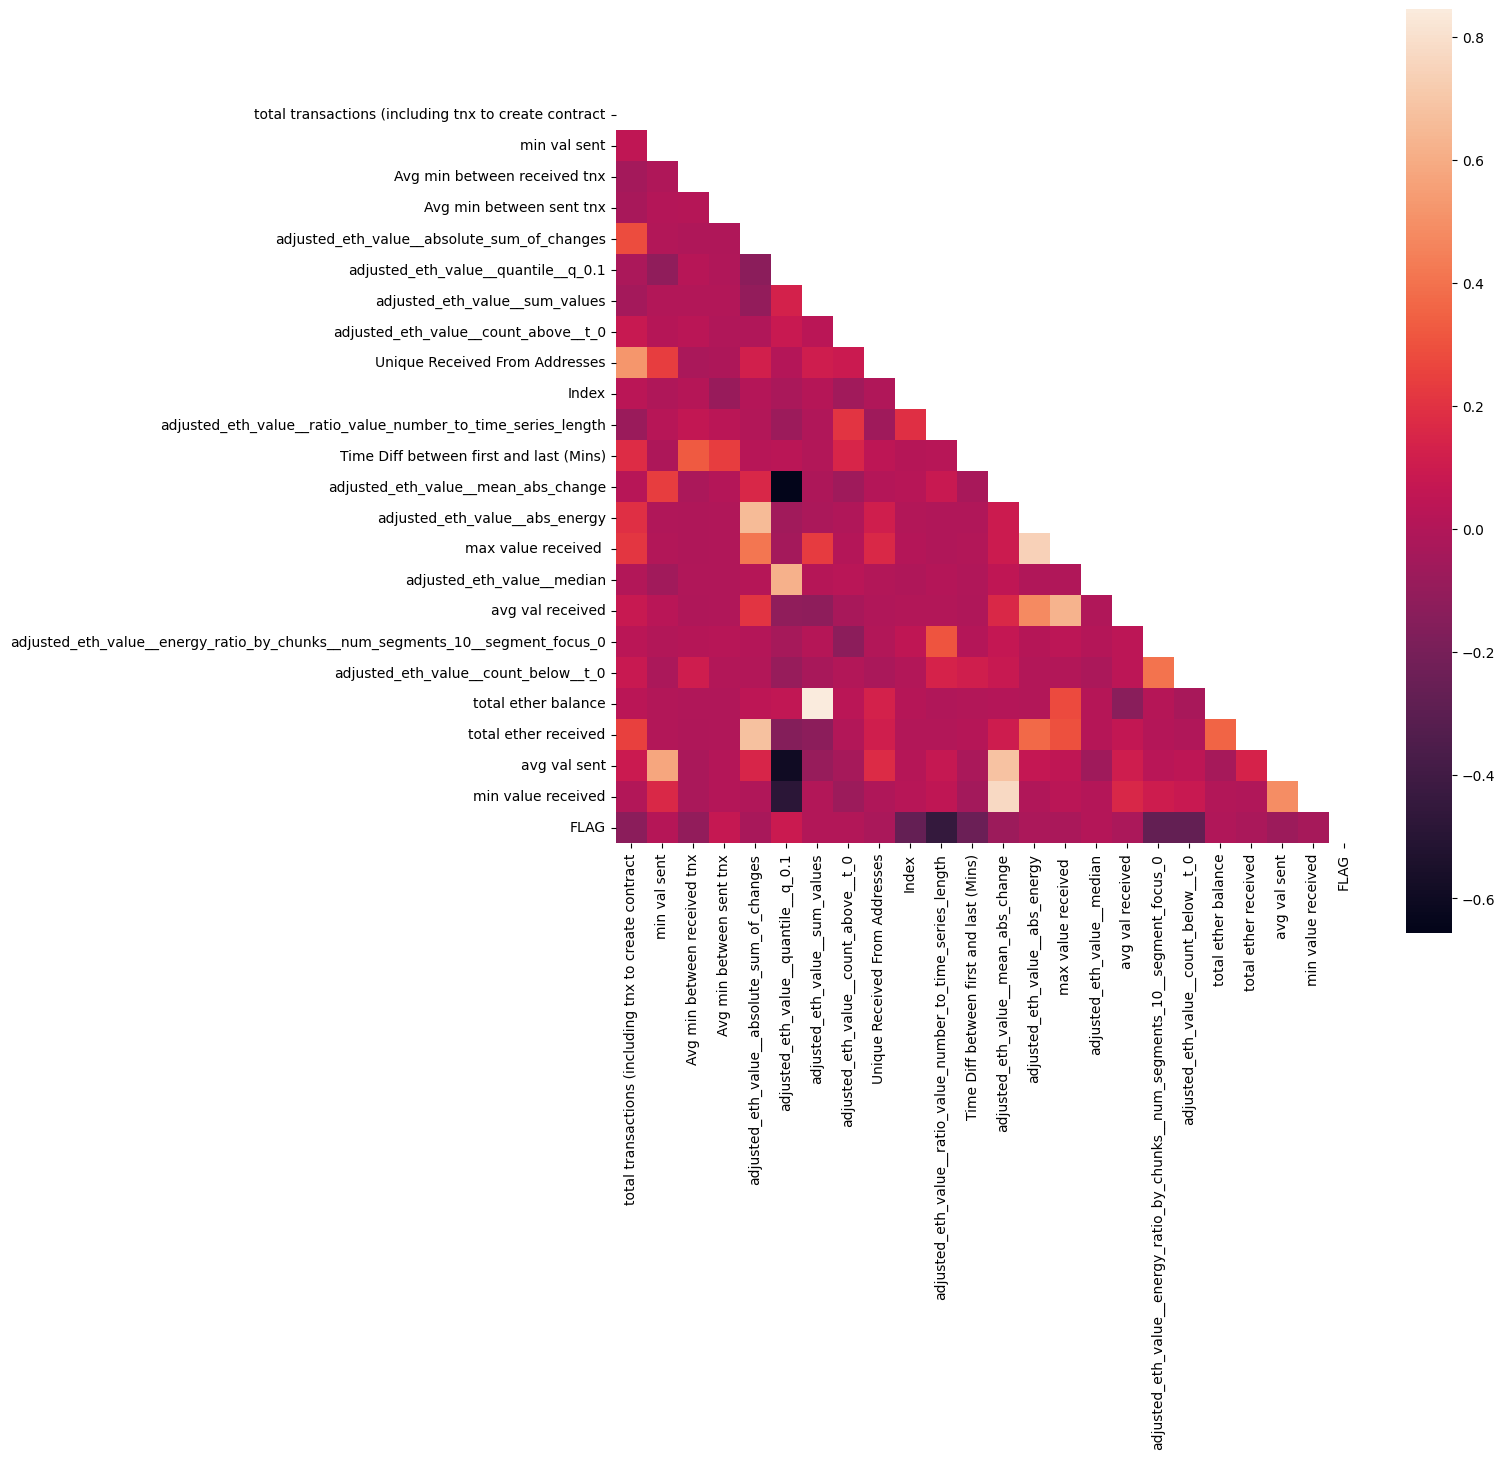

In [8]:
corr = df[feature_list + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [9]:
df[feature_list + ['FLAG']].corr()[['FLAG']]

,FLAG
total transactions (including tnx to create contract,-0.132434
min val sent,0.011914
Avg min between received tnx,-0.108093
Avg min between sent tnx,0.072284
adjusted_eth_value__absolute_sum_of_changes,-0.032498
adjusted_eth_value__quantile__q_0.1,0.088834
adjusted_eth_value__sum_values,0.000877
adjusted_eth_value__count_above__t_0,0.001290
Unique Received From Addresses,-0.026840
Index,-0.264077


In [10]:
pairs = df[feature_list].corr().stack()
pairs_list = list(pairs[pairs.abs().gt(0.9) & pairs.abs().lt(1.0)].index)
print(int(len(pairs_list) / 2))

0


In [11]:
uniq_pairs_list = []

for x, y in pairs_list:
    if (x, y) in uniq_pairs_list or (y, x) in uniq_pairs_list:
        continue
    else:
        uniq_pairs_list.append((x, y))

In [12]:
filter_cor_feature_list =  list({x[0] for x in uniq_pairs_list})
filter_cor_feature_list

[]

In [13]:
len(list(set(feature_list) - set(filter_cor_feature_list)))

23

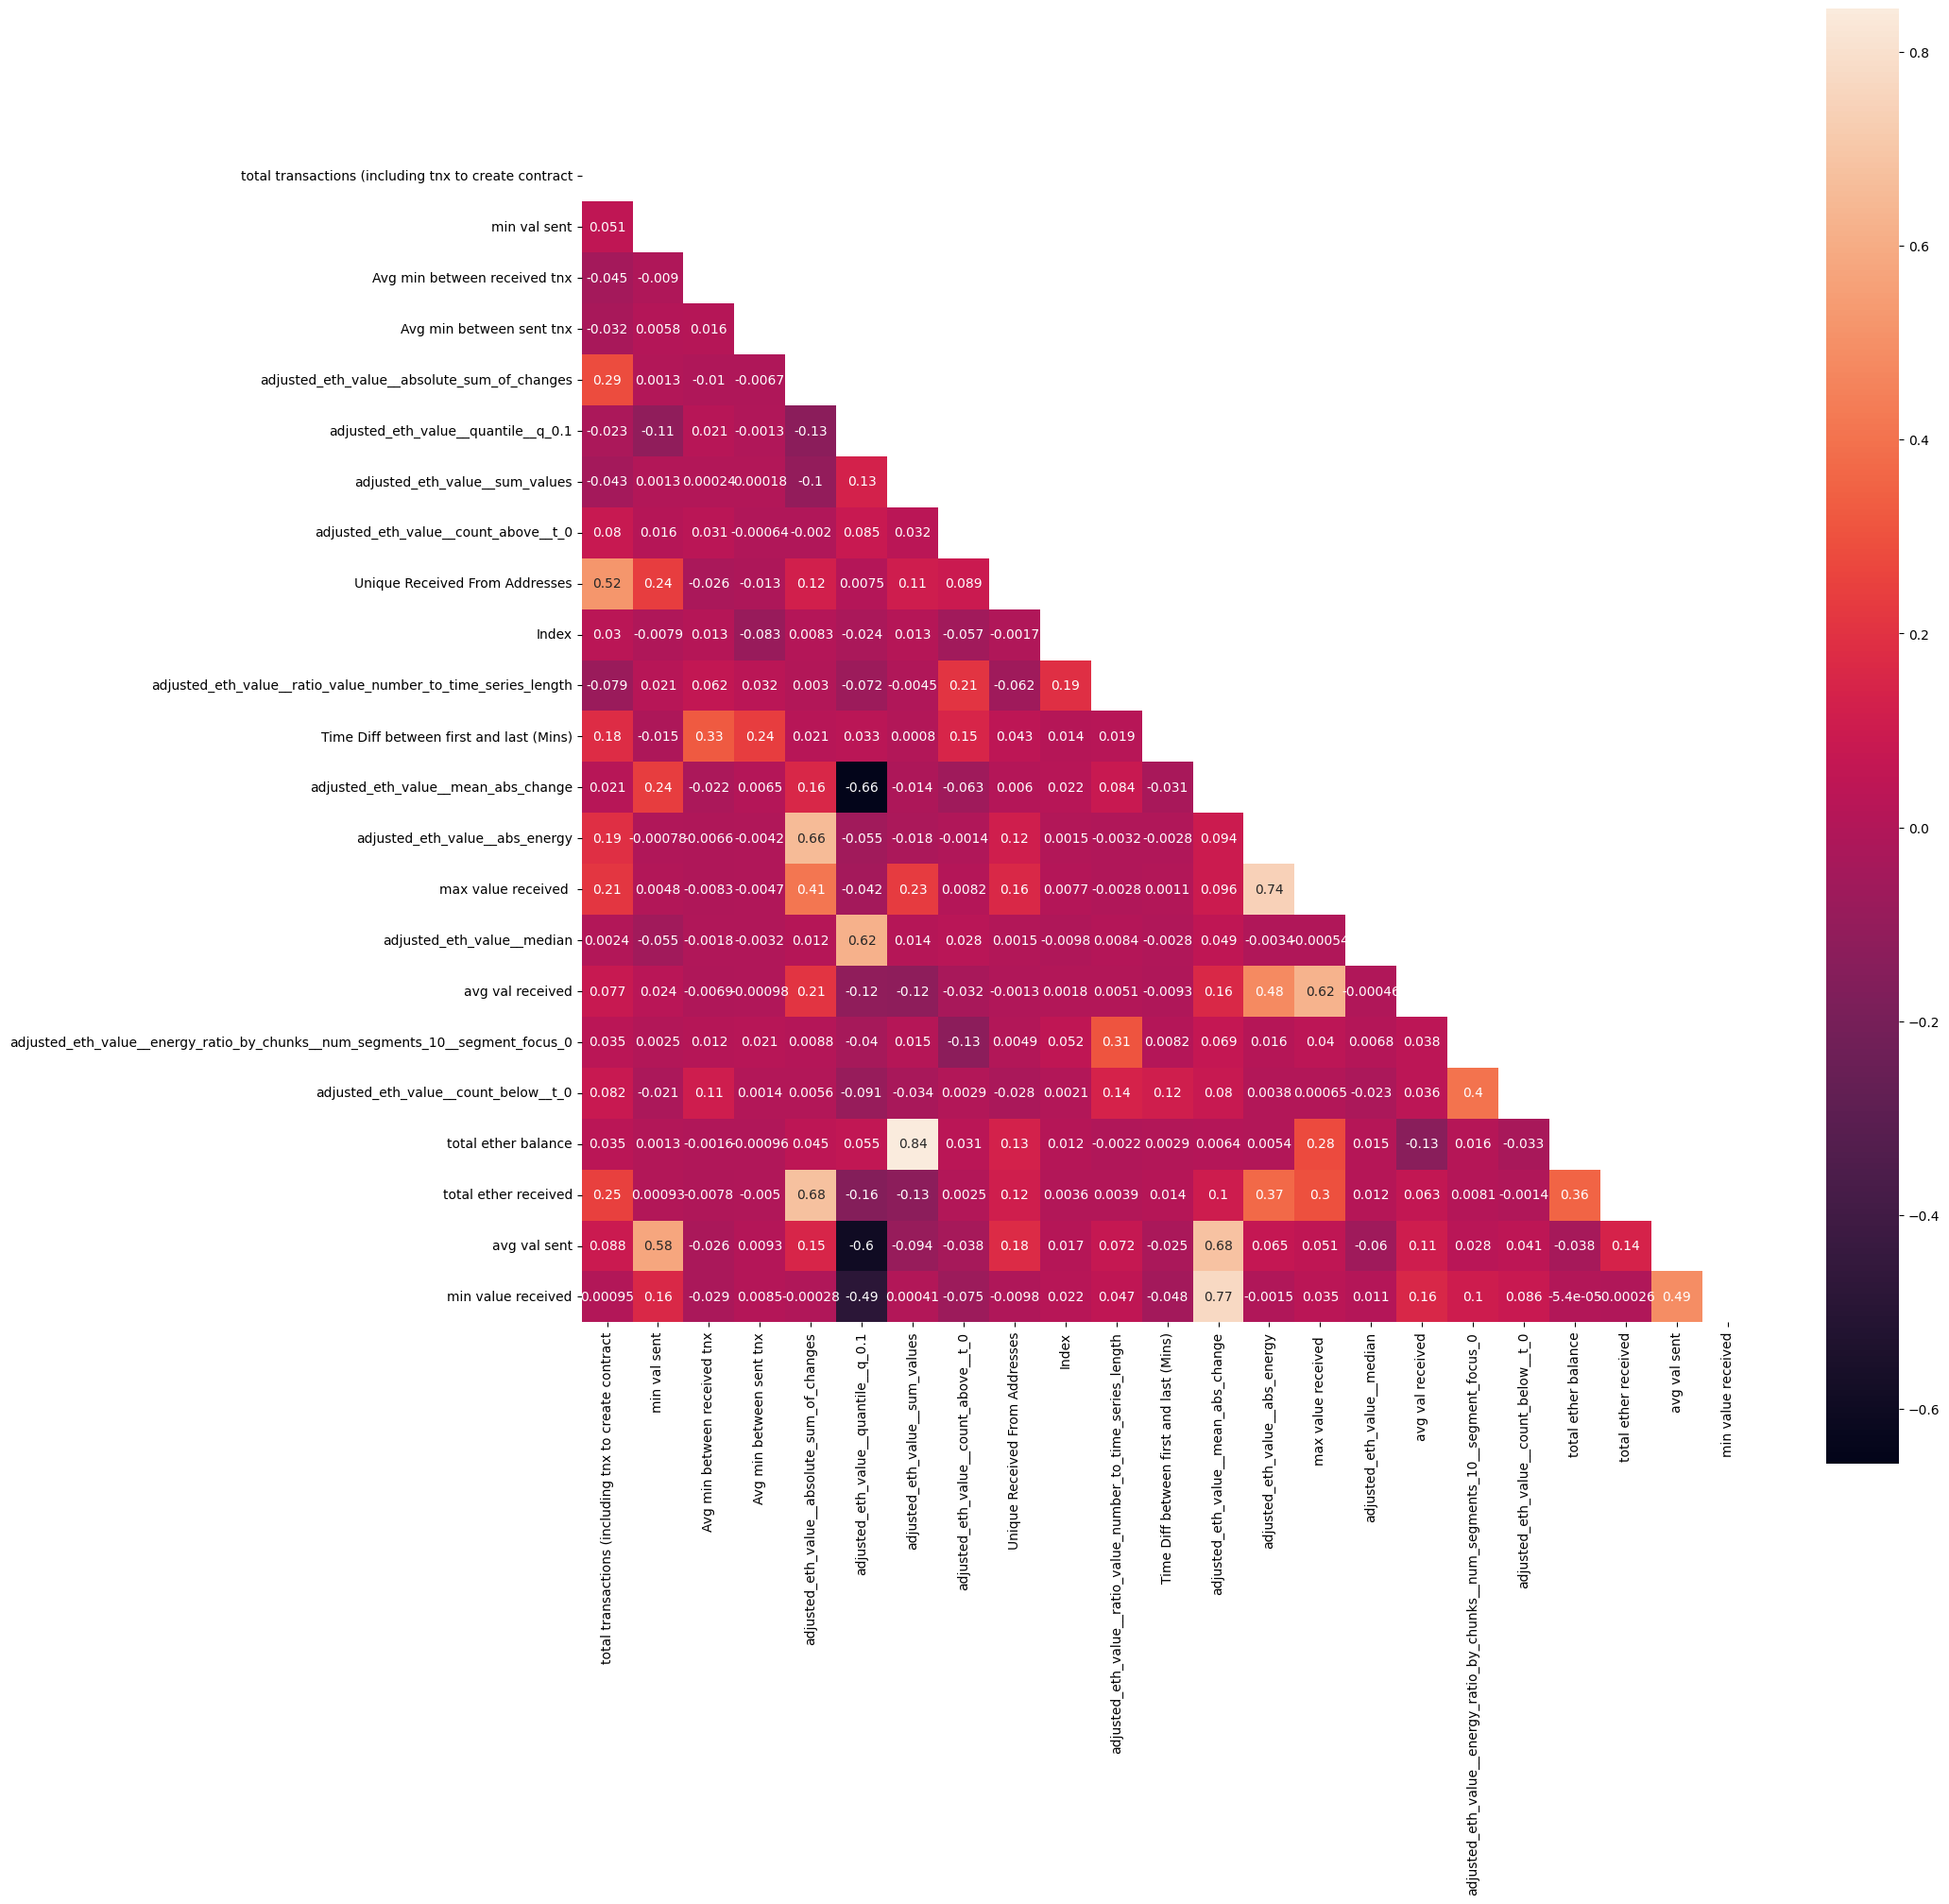

In [14]:
corr = df[list(set(feature_list) - set(filter_cor_feature_list))].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, square=True, annot=True)
plt.show()

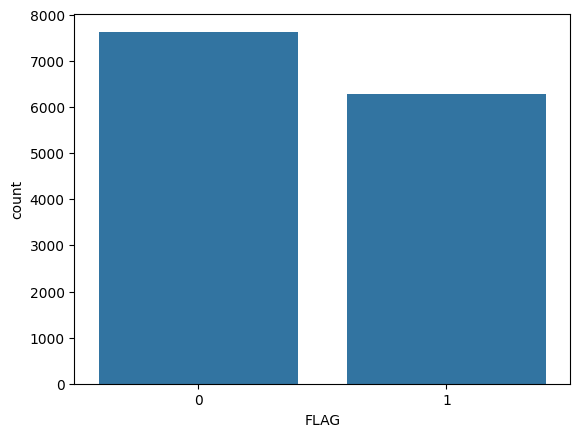

Target:  0.45136494252873566


In [15]:
sns.countplot(data=df, x='FLAG')
plt.show()
print('Target: ', df['FLAG'].mean())

In [16]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])
df_train.shape[0], df_test.shape[0]

(12528, 1392)

In [17]:
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=0, stratify=df_train['FLAG'])
df_train.shape[0], df_valid.shape[0]

(8769, 3759)

In [18]:
df_train['FLAG'].mean(), df_valid['FLAG'].mean(), df_test['FLAG'].mean()

(0.4513627551602235, 0.45144985368449053, 0.4511494252873563)

In [19]:
class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""

    def __init__(self, feature_list: list,
                 drop_feature_list: Optional[list] = None,
                 fillna: Union[int, str] = 0,
                 q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None):
        """
            `feature_list` - list with features name
            `drop_feature_list` - features to drop
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
        """
        self.feature_list = feature_list
        self.drop_feature_list = drop_feature_list
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers

    def fit(self, df):
        self.fillna_dict = {}
        self.q_up_dict = {}
        self.q_down_dict = {}

        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.feature_list:
                self.fillna_dict[feature] = 0
        else:
            for feature in self.feature_list:
                self.fillna_dict[feature] = None

        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                self.q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                self.q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)


        if self.drop_feature_list:
            self.feature_list = list(set(self.feature_list) - set(self.drop_feature_list))

        return self

    def transform(self, df):

        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)


        # numerical fillna
        for feature in self.feature_list:
            df.loc[df[feature].isna(), feature] = self.fillna_dict[feature]


        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] > self.q_up_dict[feature], feature] = self.q_up_dict[feature]

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] < self.q_down_dict[feature], feature] = self.q_down_dict[feature]


        return df

In [20]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median'
)

In [21]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [22]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [23]:
df_train_prep, df_train['FLAG']

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBClassifier, plot_importance
import time

clf = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)
params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(1000,1500,100),
    'learning_rate': [0.1, 0.01, 0.05]
}

clf = GridSearchCV(estimator=clf,
                    param_grid=params,
                    scoring='f1',
                    cv=5,
                    verbose=2,
                    )
start_time = time.time()
clf.fit(df_train_prep, df_train['FLAG'])
print(time.time() - start_time)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   2.4s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.8s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1000; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1100; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=2, n_estimators=1200; total time=   1.0s
[CV] END ..learning_rate=0.1, max_depth=2, n_e

In [27]:
print(
    'train roc_auc_score: ',
    roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1])
)
print(
    'valid roc_auc_score: ',
    roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1])
)
print(
    'test roc_auc_score: ',
    roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1])
)

train roc_auc_score:  1.0
valid roc_auc_score:  0.9999871399691473
test roc_auc_score:  0.999995831526995
